In [1]:
import matplotlib.pyplot as plt
import torch
import os
from dataclasses import dataclass

@dataclass
class ParConfig:
    num_partition:int = 4
    node_mode:str = "uniform"
    edge_mode:str = "uniform"
    bal:str = "bal"

    def name(self):
        return f"w{self.num_partition}_n{self.node_mode}_e{self.edge_mode}_{self.bal}"

def load_partition_map(graph_name, data_dir, node_mode: str, edge_mode: str, bal: str, num_partitions=4):
    in_dir = os.path.join(data_dir, "partition_ids", graph_name)
    file_name = f"{graph_name}_w{num_partitions}_n{node_mode}_e{edge_mode}_{bal}.pt"
    return torch.load(os.path.join(in_dir, file_name)).type(torch.int64)

def load_workload(graph_name, data_dir, pcfg: ParConfig):
    filename= f"{graph_name}_w{pcfg.num_partition}_n{pcfg.node_mode}_e{pcfg.edge_mode}_{pcfg.bal}.pt"    
    in_dir = os.path.join(data_dir, "workload", graph_name)
    workload = torch.load(os.path.join(in_dir, filename))
    return workload

def load_idx_split(in_dir, is32=False) -> (torch.Tensor, torch.Tensor, torch.Tensor):
    # graph_name = in_dir.split("/")[-1]
    # if graph_name in ["orkut", "friendster"]:
    #     data_dir = "/data/juelin/project/scratch/dgl/experiment/dataset"
    #     in_dir = os.path.join(data_dir, graph_name)
    
    print("load idx split from", in_dir)
    train_idx = torch.load(os.path.join(in_dir, f"train_idx.pt"))
    valid_idx = torch.load(os.path.join(in_dir, f"valid_idx.pt"))
    test_idx = torch.load(os.path.join(in_dir, f"test_idx.pt"))
    if is32:
        return train_idx.type(torch.int32), valid_idx.type(torch.int32), test_idx.type(torch.int32)
    else:
        return train_idx, valid_idx, test_idx

def plots(name2workload, mode, outpath=None):
    font = {'size' : 16} 
    plt.rc('font', **font)
    
    fig, ax = plt.subplots(figsize=(6, 4))
        
    node2color = {"nuniform": "gray",
                 "ndegree": "gold",
                 "ndst": "tab:blue",
                 "nrandom": "tab:red"}
    edge2color = {"euniform": "tab:purple",
             "efreq": "tab:blue"}
    
    def get_color(node_mode, edge_mode, bal):
        if node_mode == "ndst":
            return edge2color[edge_mode]
        else:
            return node2color[node_mode]
        
    def get_label(node_mode, edge_mode, bal):
        if node_mode == "nrandom":
            return "Random"
        if node_mode == "nuniform":
            return "Node"
        elif node_mode == "ndegree":
            return "Edge"
        elif node_mode == "ndst":
            if edge_mode == "euniform":
                return "Split w/o escore"
            else:
                return "Split"
            
        print("Invalid input", node_mode, edge_mode, bal)
        return "Null Label"
    
    step = 0
    num_bins = 100 // len(name2workload.items())
    
    for pname, workload in name2workload.items():
        
        world_size, vmode, edge_weight, bal = pname.split("_")

        def slice_row(row:torch.Tensor,start:int, step:int):
            return row[start:row.shape[0]:step]
        
        tsrc = slice_row(workload["src"], 0, 3)
        tdst = slice_row(workload["dst"], 0, 3)
        tloc = slice_row(workload["loc"], 0, 3)
        tcrs = slice_row(workload["crs"], 0, 3)
        tinput = slice_row(workload["input"], 0, 3)
        tsum = tcrs + tloc
        width = 0.5
        tsmax, tsmax_idx = torch.max(tsum, dim=1)
        timax, timax_idx = torch.max(tinput, dim=1)
        tcsum = torch.sum(tcrs, dim=1)
        
        label = get_label(vmode, edge_weight, bal)
        color = get_color(vmode, edge_weight, bal)
        
        if mode == "edge":
            x = tsmax / torch.sum(tsum, dim=1) * 4
            ax.hist(x, bins=num_bins, label=label, alpha = 0.6, color=color)
            # error bar
            ymin, ymax = plt.ylim()
            ylow = ymax / 3
            yhigh = ymax / 3 * 2
            y = torch.randint(low=int(ylow), high=int(yhigh), size=(1,))
            x_mean = torch.mean(x)
            x_std = torch.std(x)
            ax.errorbar(x=x_mean, y=y, xerr=x_std, capsize=5, capthick=3, color=color)
            
        elif mode == "crs":
            x = tcsum / torch.sum(tsum, dim=1)
            ax.hist(x, bins=num_bins, label=label, alpha = 0.6, color=color)
            # error bar
            ymin, ymax = plt.ylim()
            ylow = ymax / 3
            yhigh = ymax / 3 * 2
            y = torch.randint(low=int(ylow), high=int(yhigh), size=(1,))
            x_mean = torch.mean(x)
            x_std = torch.std(x)
            ax.errorbar(x=x_mean, y=y, xerr=x_std, capsize=5, capthick=3, color=color)
        elif mode == "input":
            x = timax / torch.sum(tinput, dim=1) * 4
            ax.hist(x, bins=num_bins, label=label, alpha = 0.6, color=color)
            # error bar 
            ymin, ymax = plt.ylim()
            ylow = ymax / 3
            yhigh = ymax / 3 * 2
            y = torch.randint(low=int(ylow), high=int(yhigh), size=(1,))
            x_mean = torch.mean(x)
            x_std = torch.std(x)
            ax.errorbar(x=x_mean, y=y, xerr=x_std, capsize=5, capthick=3, color=color)
        step += 1
        
    ax.set_title("Workload Inbalance of Mini-Batches")
    ax.set_ylabel("Frequency")
    if mode == "edge":
        ax.set_xlabel("# Max Edges / Average Edges")
    elif mode == "crs":
        ax.set_xlabel("# Cross Edges / Edges")
    elif mode == "input":
        ax.set_xlabel("# Max Dataloading / Average Dataloading")

    plt.tight_layout()
    plt.legend()
    if outpath != None:
        plt.savefig(outpath)
    plt.show()

def plot_one(graph_name, data_dir, pcfg: ParConfig):
    plot_prefix = f"{graph_name}_{pcfg.name()}"
    
    workload = load_workload(graph_name, data_dir, pcfg)
    train_idx, _, _ = load_idx_split(os.path.join(data_dir, graph_name))
    partition_map = load_partition_map(graph_name, data_dir, pcfg.node_mode, pcfg.edge_mode, pcfg.bal)
    train_map = partition_map[train_idx]
    train_dist = torch.bincount(train_map, minlength=pcfg.num_partition)
    
    def slice_row(row:torch.Tensor,start:int, step:int):
        return row[start:row.shape[0]:step]
    
    tsrc = slice_row(workload["src"], 0, 3)
    tdst = slice_row(workload["dst"], 0, 3)
    tloc = slice_row(workload["loc"], 0, 3)
    tcrs = slice_row(workload["crs"], 0, 3)
    tinput = slice_row(workload["input"], 0, 3)
    
    tsum = tcrs + tloc
    # crs_workloads = torch.div(tcrs, torch.sum(tsum, dim=1).reshape(-1, 1))
    # loc_workloads = torch.div(tloc, torch.sum(tsum, dim=1).reshape(-1, 1))
    # src_workloads = torch.div(tsrc, torch.sum(tsrc, dim=1).reshape(-1, 1))
    # dst_workloads = torch.div(tdst, torch.sum(tdst, dim=1).reshape(-1, 1))
    # edge_workloads = torch.div(tsum, torch.sum(tsum, dim=1).reshape(-1, 1))
    # input_workloads = torch.div(tinput, torch.sum(tinput, dim=1).reshape(-1, 1))

    # data from https://allisonhorst.github.io/palmerpenguins/
    tdist = (train_dist / torch.sum(train_dist))
    xticks = [f"P{i}" for i in range(4)]
    cnts = {
        "Local Edges": torch.sum(tloc, dim=0),
        "Cross Edges": torch.sum(tcrs, dim=0),
        "Dataloading": torch.sum(tinput, dim=0)
    }
    width = 0.5

    fig, ax = plt.subplots(figsize=(10, 6))
    bottom = torch.zeros((4,), dtype=torch.int64)
    font = {'size' : 18} 
    plt.rc('font', **font)
    for label, cnt in cnts.items():
        p = ax.bar(xticks, cnt, width, label=label, bottom=bottom)
        bottom += cnt

    ax2 = ax.twinx()
    ax2.plot(xticks, tdist, label="target distribution", color="red")
    ax2.set_ylabel("Percentage")
    ax2.set_ylim(ymin=0, ymax=0.5)
        
    ax.set_title(f"{plot_prefix} Overall Workloads")
    ax.set_ylabel("Number of Edges")
    ax.legend()
    ax2.legend(loc="lower right")
    plt.tight_layout()
    plt.show()
    
    tmax, tmax_idx = torch.max(tsum, dim=1)
    x = tmax / torch.sum(tsum, dim=1) * 4
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.ecdf(x)
    ax.set_title(f"{plot_prefix} Computation Workload CDF")
    ax.set_ylabel("CDF")
    ax.set_xlabel("Max Edges / Average Edges")
    plt.tight_layout()
    plt.show()
    
    tmax, tmax_idx = torch.max(tinput, dim=1)
    x = tmax / torch.sum(tinput, dim=1) * 4
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.ecdf(x)
    ax.set_title(f"{plot_prefix} Dataloading Workload CDF")
    ax.set_ylabel("CDF")
    ax.set_xlabel("Max Dataloading / Average Dataloading Nodes")
    plt.tight_layout()
    plt.show()

# Workload Balancing Techiques

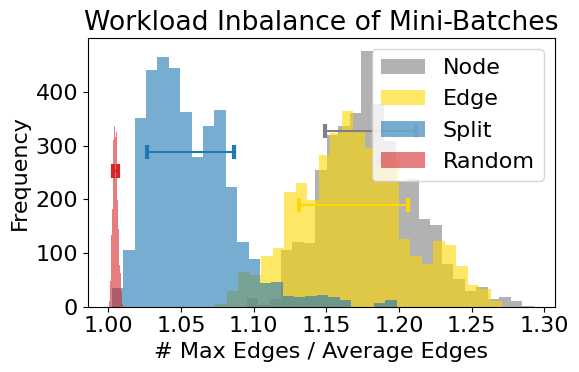

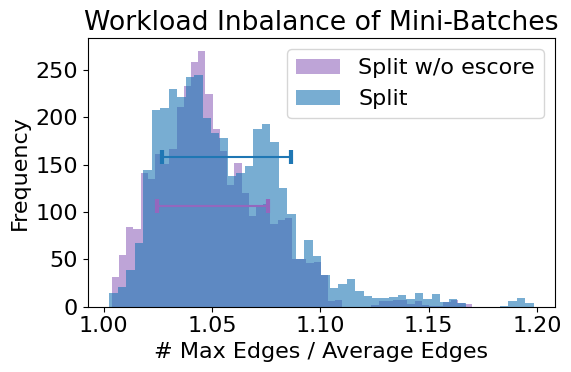

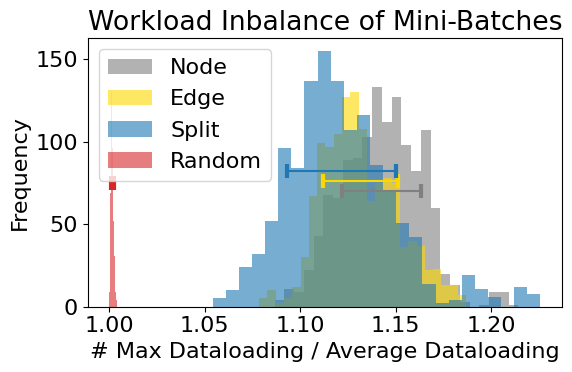

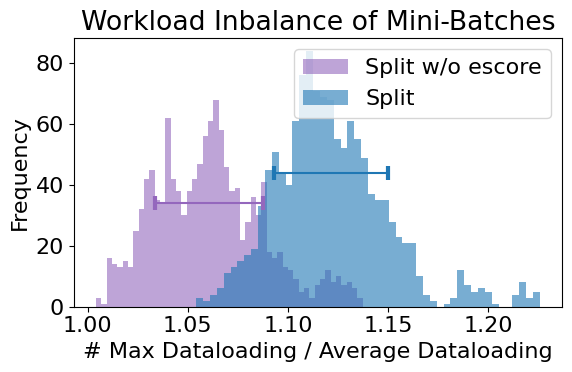

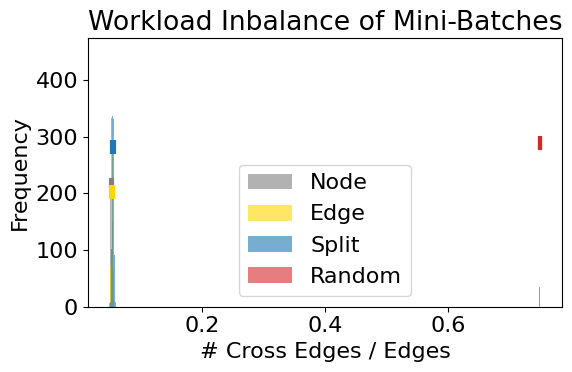

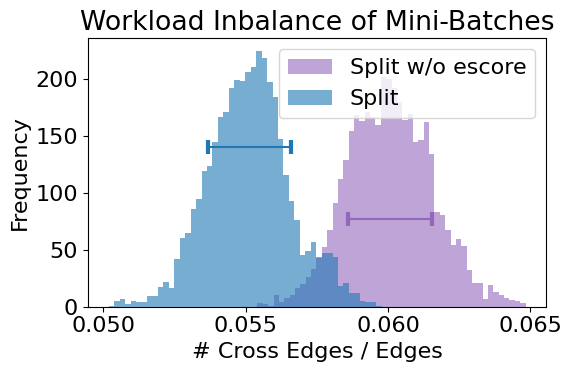

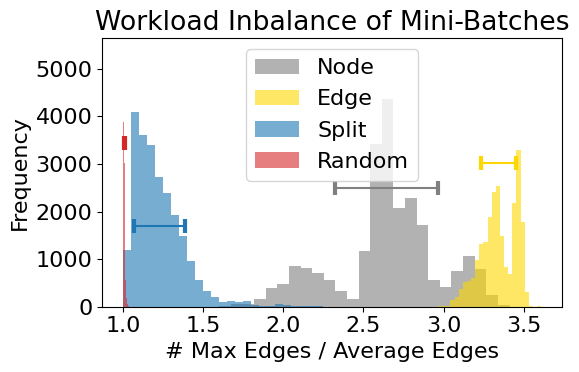

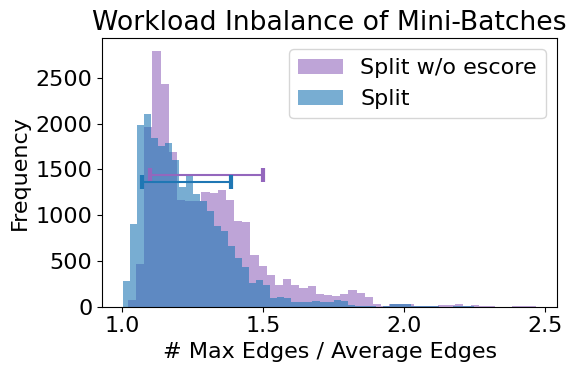

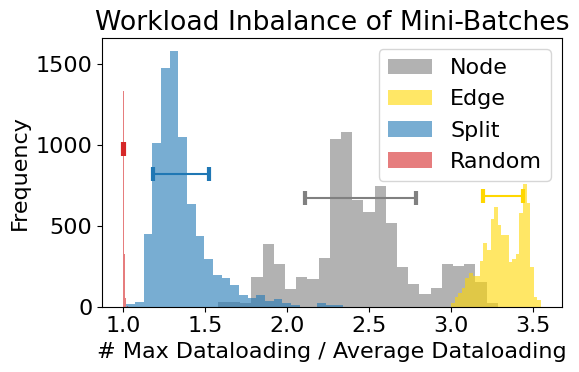

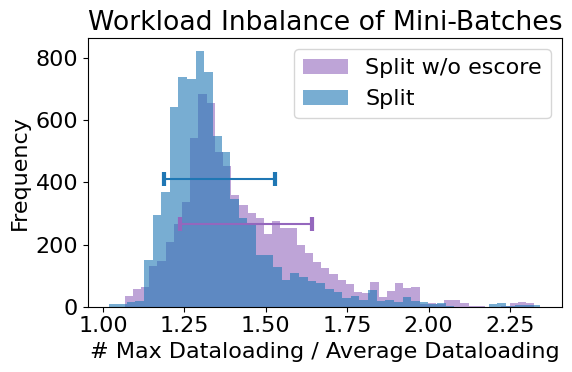

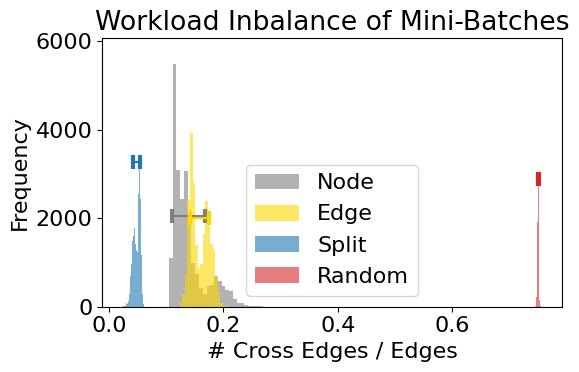

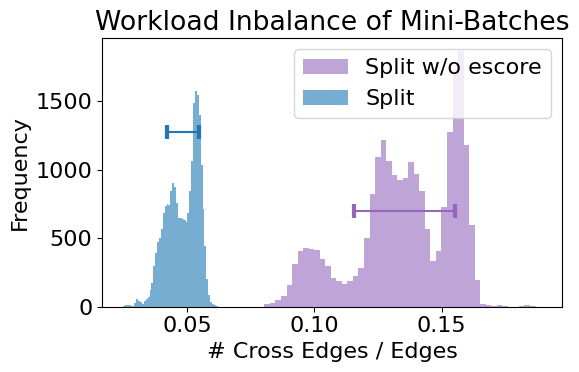

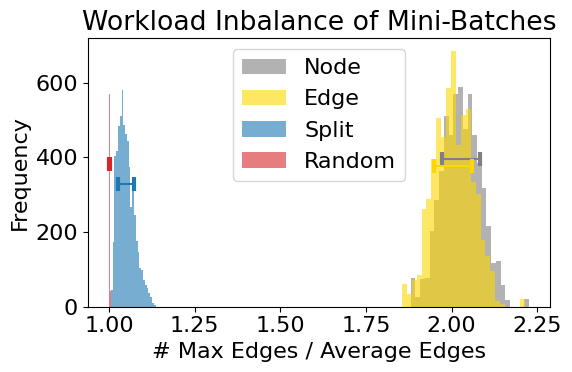

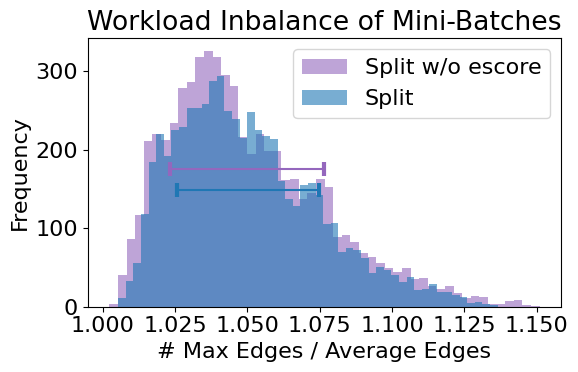

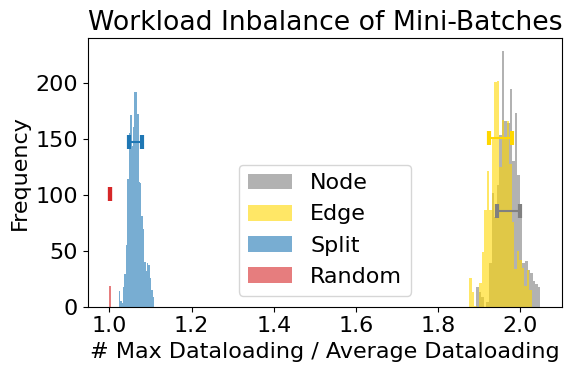

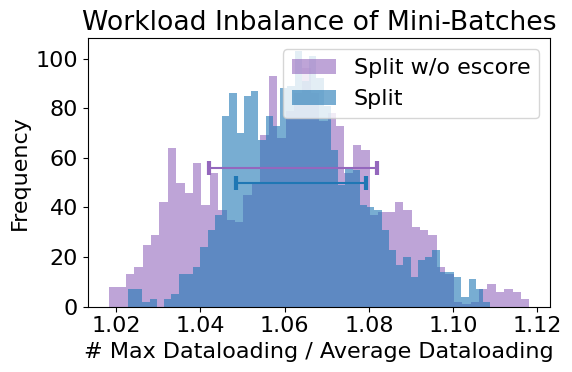

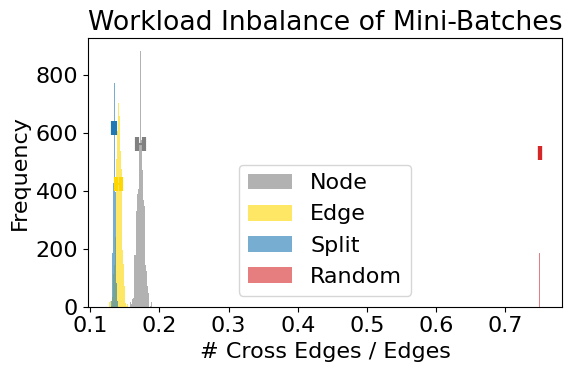

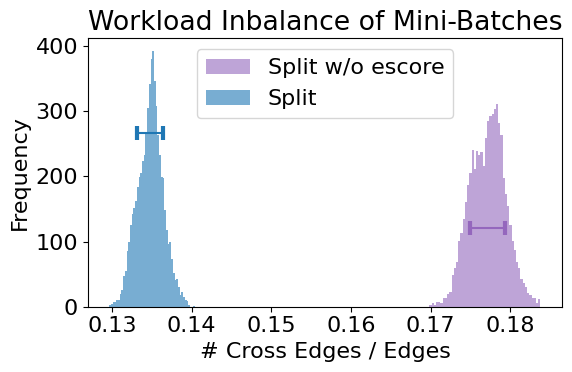

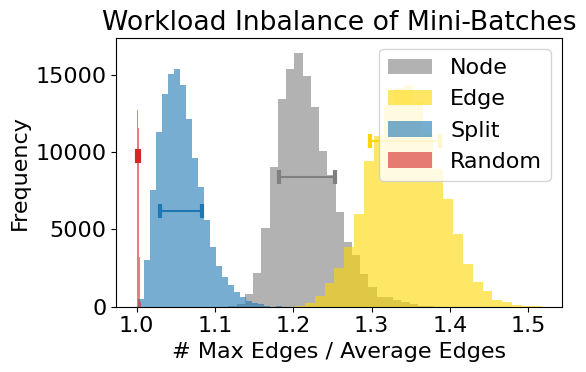

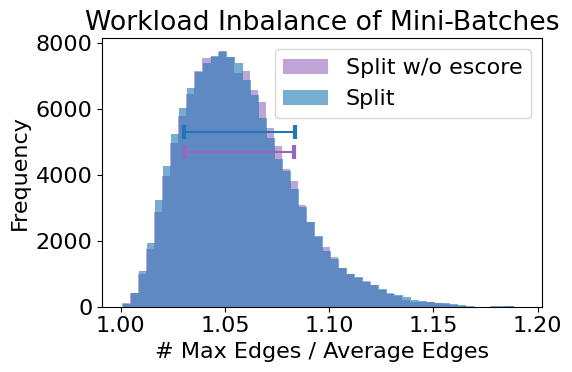

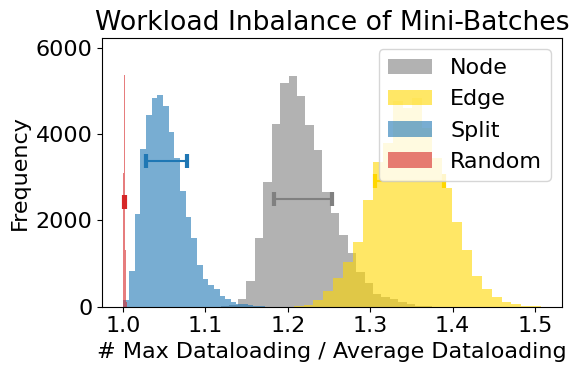

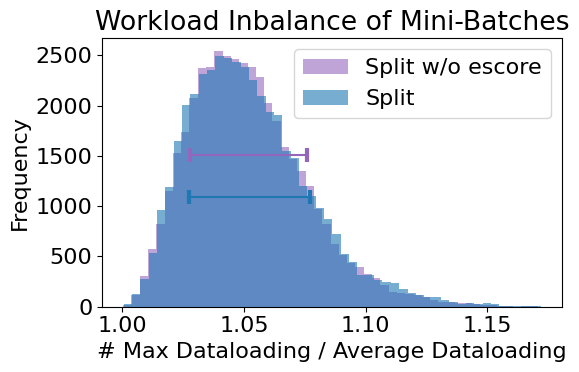

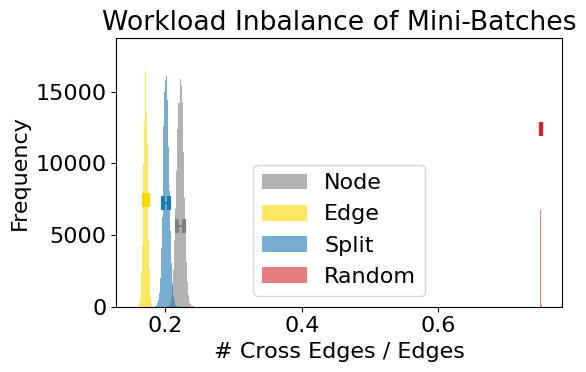

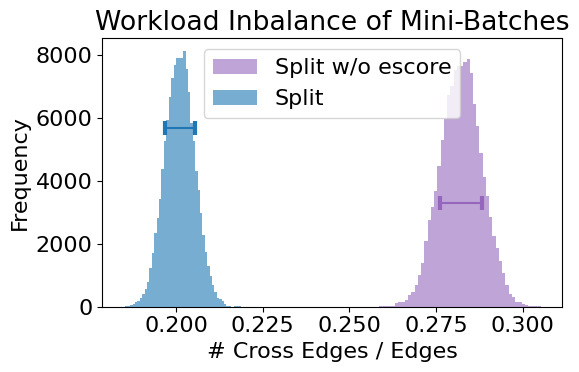

In [2]:
def get_workload_bal(graph_name, data_dir):
    name2work = {}
    pcfgs = []

    #baseline
    for node_mode in ["uniform", "degree"]:
        pcfg = ParConfig(node_mode=node_mode, edge_mode="uniform", bal="bal")
        pcfgs.append(pcfg)

    #freq based workload balancing
    for node_mode in ["dst"]:
        for edge_mode in ["freq"]:
            for bal in ["xbal"]:
                pcfg = ParConfig(node_mode=node_mode, edge_mode=edge_mode, bal=bal)
                pcfgs.append(pcfg)
    pcfg = ParConfig(node_mode="random", edge_mode="random", bal="xbal")
    pcfgs.append(pcfg)
    for pcfg in pcfgs:
        workload = load_workload(graph_name, data_dir, pcfg)
        name2work[pcfg.name()] = workload
    return name2work

def get_workload_comm(graph_name, data_dir):
    name2work = {}
    pcfgs = []
    #baseline
    # for node_mode in ["uniform", "degree"]:
    #     pcfg = ParConfig(node_mode=node_mode, edge_mode="uniform", bal="bal")
    #     pcfgs.append(pcfg)
        
    for node_mode in ["dst"]:
        for edge_mode in ["uniform", "freq"]:
            for bal in ["xbal"]:
                pcfg = ParConfig(node_mode=node_mode, edge_mode=edge_mode, bal=bal)
                pcfgs.append(pcfg)
    # pcfg = ParConfig(node_mode="random", edge_mode="random", bal="xbal")
    pcfgs.append(pcfg)
    for pcfg in pcfgs:
        workload = load_workload(graph_name, data_dir, pcfg)
        name2work[pcfg.name()] = workload
    return name2work

data_dir = "../../dataset/graph/"
for graph_name in ["products", "papers100M", "orkut", "friendster"]:
# for graph_name in ["products"]:
    name2work_bal = get_workload_bal(graph_name, data_dir)
    name2work_comm = get_workload_comm(graph_name, data_dir)
    for plot_mode in ["edge", "input", "crs"]:
    # for plot_mode in ["edge"]:
        plots(name2work_bal, plot_mode, f"plots/{graph_name}_{plot_mode}_bal.png")
        plots(name2work_comm, plot_mode, f"plots/{graph_name}_{plot_mode}_com.png")
